# **Leaf Disease Detection**

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Machine_Learning/kaggle/"

In [ ]:
#!kaggle datasets download -d dev523/leaf-disease-detection-dataset
#!kaggle datasets download -d saiabhitejachepuri/final-year-project-tree
!kaggle datasets download -d kaustubhb999/tomatoleaf

100% 179M/179M [00:05<00:00, 44.2MB/s]
100% 179M/179M [00:05<00:00, 35.8MB/s]


In [ ]:
#Warning: Your Kaggle API key is readable by other users on this system! To fix this, you can run 'chmod 600 /content/kaggle.json'
!chmod 600 /content/drive/MyDrive/Machine_Learning/kaggle/kaggle.json

In [ ]:
#What ever the files were zipped are unzipped and removes the zipped files.
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: tomato/train/Tomato___Target_Spot/002213fb-b620-4593-b9ac-6a6cc119b100___Com.G_TgS_FL 8360.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0044d10f-7062-4655-8abd-9fffc5b2f152___Com.G_TgS_FL 7908.JPG  
  inflating: tomato/train/Tomato___Target_Spot/00854623-ba28-446d-a1d5-03c0ae3f99d9___Com.G_TgS_FL 7949.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0118c27a-f34a-41e1-8b2f-d2c564f83c5c___Com.G_TgS_FL 0013.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0118ed61-b135-45be-ad81-7e2d54203be4___Com.G_TgS_FL 8241.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0197df47-a9cb-4b6c-b72c-ac0e9af6d135___Com.G_TgS_FL 0779.JPG  
  inflating: tomato/train/Tomato___Target_Spot/025510ac-15db-4861-b02b-21da82161100___Com.G_TgS_FL 0952.JPG  
  inflating: tomato/train/Tomato___Target_Spot/0288164e-d6cf-4215-b593-7b581308a4cf___Com.G_TgS_FL 9777.JPG  
  inflating: tomato/train/Tomato___Target_Spot/03002b91-afe3-4c72-86b

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

**Data Preparation**

In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [ ]:
Dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/tomato/train',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 10000 files belonging to 10 classes.


In [ ]:
len(Dataset)#No. of Batches dived with each batch size of 32 Records.

313

In [ ]:
class_names = Dataset.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [ ]:
for image_batch, label_batch in Dataset.take(1):
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[0 7 4 4 9 9 1 7 1 5 6 9 4 4 8 6 5 0 4 2 5 6 7 1 2 1 6 7 1 7 3 2]


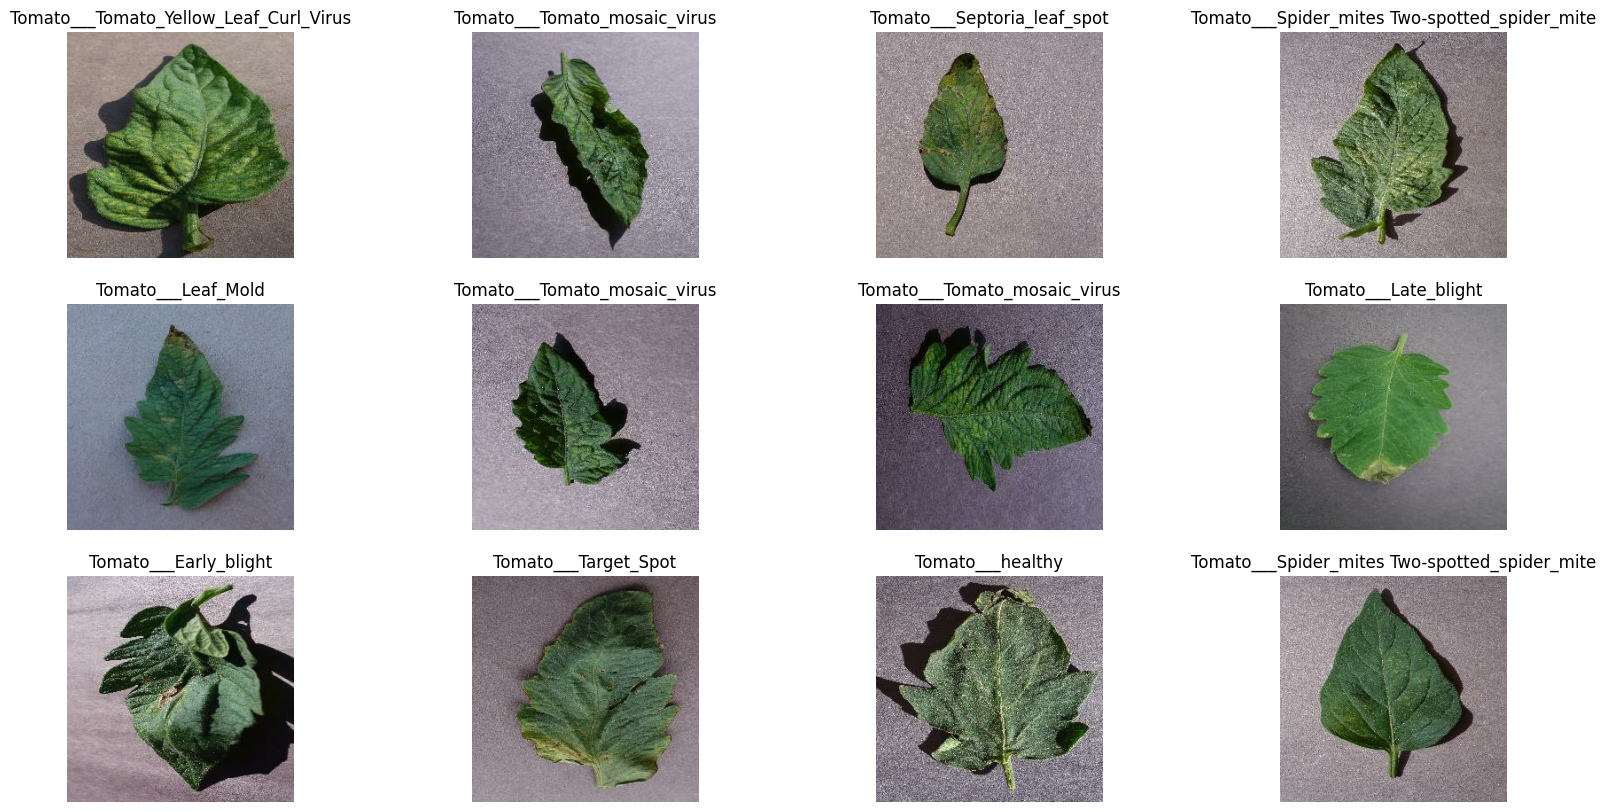

In [ ]:
plt.figure(figsize = (20, 10))
for image_batch, label_batch in Dataset.take(1):
  for i in range(12):
    AX = plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

**Splitting Dataset**

In [ ]:
def Split_Dataset(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1 , shuffle = True, shuffle_size = 10000):

  """
    80% ==> training
    20% ==> 10% validation, 10% test
  """

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed = 12)

  train_size = int(ds_size * train_split)
  val_size = int(ds_size * val_split)

  X_train = Dataset.take(train_size)

  val_data = Dataset.skip(train_size).take(val_size)
  X_test = Dataset.skip(train_size).skip(val_size)
  print(f"Training Size - {len(X_train)}, Validation Size - {len(val_data)}, Test Size - {len(X_test)}")

  return X_train, val_data, X_test

In [ ]:
X_train, val_data, X_test = Split_Dataset(Dataset)

Training Size - 250, Validation Size - 31, Test Size - 32


## **CNN**

In [ ]:
#Making the Images if more than the dimensions it will Resize it and after resizing it will Rescale the Images.
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 255),
])

In [ ]:
#Making Our Model Robust - Traing our model with different angles of same image for predicting if any image is in different way.
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
#CNN Model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10
EPOCHS = 50

cnn = models.Sequential([
    #CNN
    resize_and_rescale,
    data_augmentation,

    #ConvLayer('filters', 'kernel_size - filter size like 3 * 3 matrix', 'activation function' , 'input shape')
    layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(filters = 64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, kernel_size = (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation = 'relu'),
    layers.MaxPooling2D((2, 2)),

    #Dense Layer
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax')
])

cnn.build(input_shape = input_shape)

In [ ]:
cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [ ]:
cnn.compile(optimizer = 'adam',
            loss = 'sparse_categorical_crossentropy',
            metrics = ['accuracy'])

In [ ]:
history = cnn.fit(X_train, batch_size = BATCH_SIZE, epochs = EPOCHS, verbose = 1, validation_data = val_data)
history

Epoch 1/50
250/250 [==============================] - 37s 114ms/step - loss: 1.7498 - accuracy: 0.3496 - val_loss: 1.8304 - val_accuracy: 0.4405
Epoch 2/50
250/250 [==============================] - 39s 157ms/step - loss: 1.0986 - accuracy: 0.6169 - val_loss: 1.6582 - val_accuracy: 0.5020
Epoch 3/50
250/250 [==============================] - 39s 156ms/step - loss: 0.8204 - accuracy: 0.7057 - val_loss: 2.1020 - val_accuracy: 0.5091
Epoch 4/50
250/250 [==============================] - 29s 114ms/step - loss: 0.6874 - accuracy: 0.7490 - val_loss: 1.2180 - val_accuracy: 0.6714
Epoch 5/50
250/250 [==============================] - 25s 101ms/step - loss: 0.5931 - accuracy: 0.7881 - val_loss: 0.8037 - val_accuracy: 0.7440
Epoch 6/50
250/250 [==============================] - 26s 104ms/step - loss: 0.5533 - accuracy: 0.8010 - val_loss: 1.0178 - val_accuracy: 0.7016
Epoch 7/50
250/250 [==============================] - 29s 113ms/step - loss: 0.4532 - accuracy: 0.8386 - val_loss: 0.9979 - val_ac

In [ ]:
scores = cnn.evaluate(X_test)

32/32 [==============================] - 7s 35ms/step - loss: 0.3284 - accuracy: 0.9067


In [ ]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 250}

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

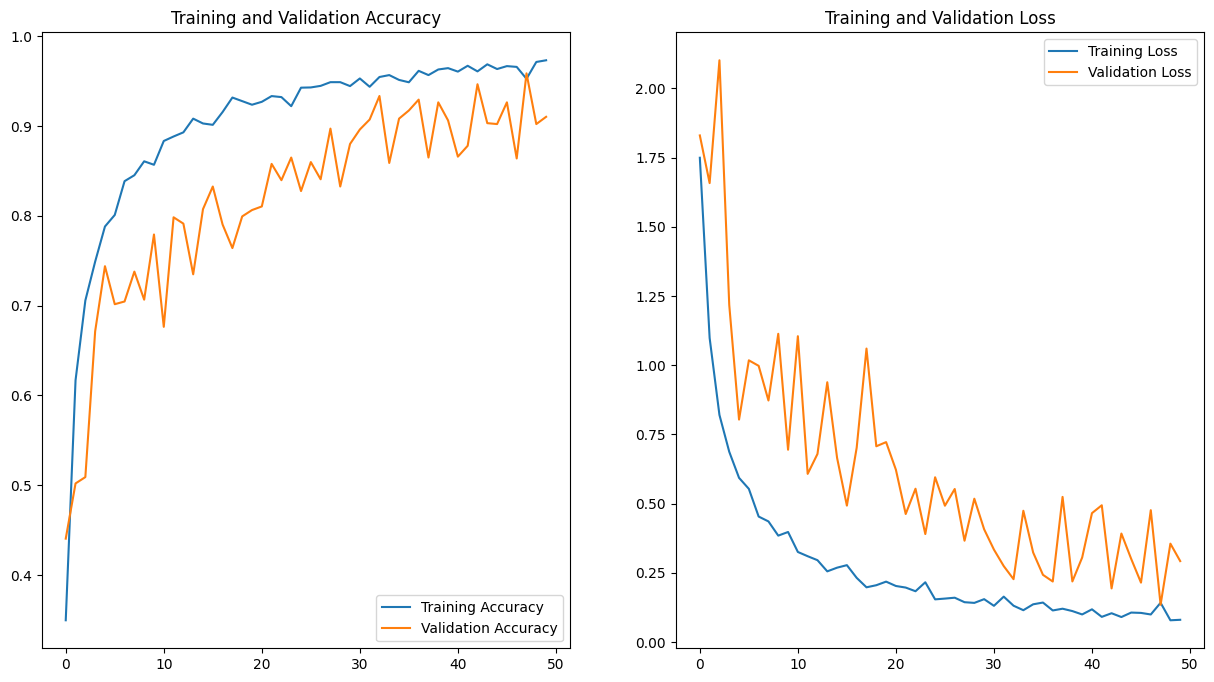

In [ ]:
plt.figure(figsize = (15, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.show()

First Image to Predict
First Image Actual Label -  Tomato___Septoria_leaf_spot
1/1 [==============================] - 0s 149ms/step
Predicted Label -  Tomato___Septoria_leaf_spot


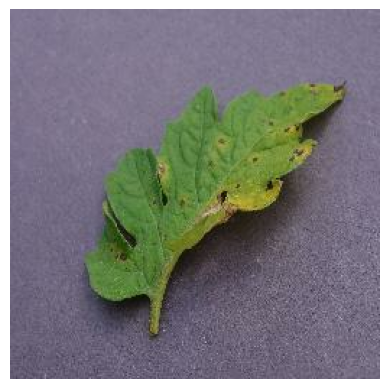

In [ ]:
for image_batch, label_batch in X_test.take(1):
  first_image = image_batch[0].numpy().astype('uint8')
  first_label = label_batch[0]

  print("First Image to Predict")
  plt.imshow(first_image)
  print("First Image Actual Label - ", class_names[first_label.numpy()])
  batch_prediction = cnn.predict(image_batch)
  print("Predicted Label - ", class_names[np.argmax(batch_prediction[0])])
  plt.axis('off')

## **Prediction**

In [ ]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0) #Create a Batch

  y_pred = model.predict(img_array)
  #print(y_pred)
  #print(np.argmax(y_pred[0]))
  predicted_class = class_names[np.argmax(y_pred[0])]
  confidence = round(100* (np.max(y_pred[0])), 2)
  return predicted_class, confidence

1/1 [==============================] - 0s 19ms/step


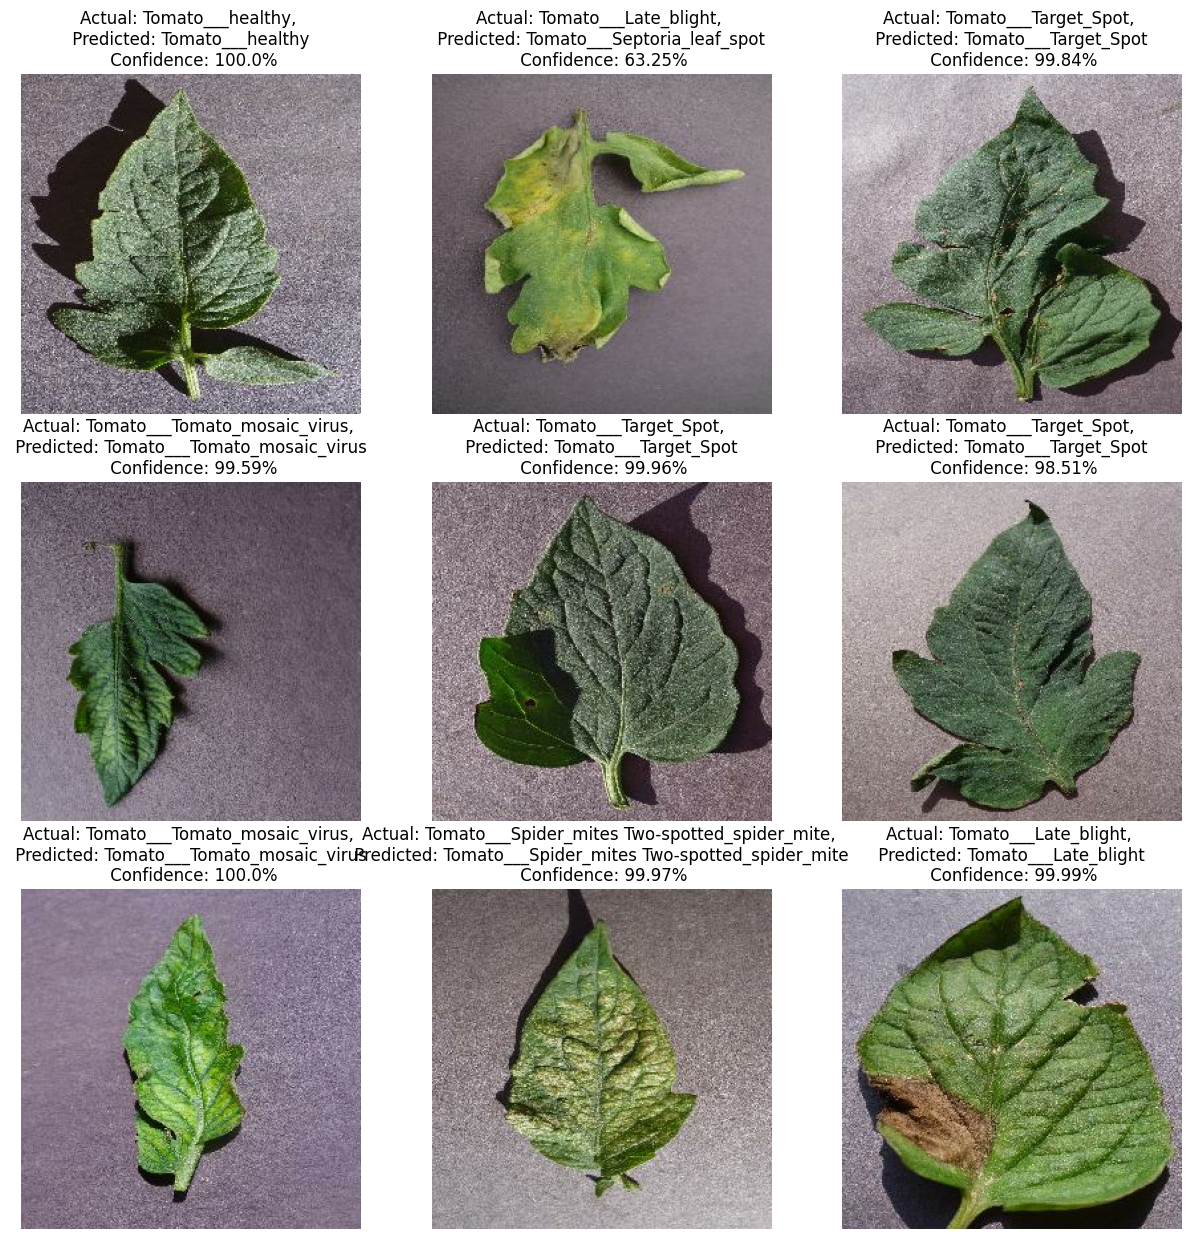

In [ ]:
plt.figure(figsize = (15, 15))
for images, labels in X_test.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3 , i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class, confidence = predict(cnn, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class} \n Confidence: {confidence}%")

    plt.axis('off')

## **User Input Prediction**

In [ ]:
from tensorflow.keras.preprocessing import image
import cv2
def predict_img(path, IMAGE_SIZE):
  img = image.load_img(path, target_size = (IMAGE_SIZE, IMAGE_SIZE))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array, axis = 0)
  #images = np.vstack([img_array])
  y_pred = cnn.predict(img_array)
  print(y_pred)
  print(np.argmax(y_pred[0]))
  predicted_class = class_names[np.argmax(y_pred[0])]
  confidence = round(100* (np.max(y_pred[0])), 2)

  return img, predicted_class, confidence

1/1 [==============================] - 0s 20ms/step
[[5.5796812e-10 4.7779537e-07 5.2817178e-10 1.0118027e-11 9.9999952e-01
  7.3108520e-16 4.9564304e-09 1.3049144e-19 2.7630821e-20 1.4835634e-30]]
4


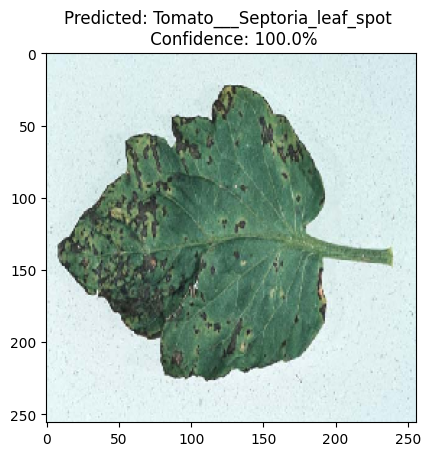

In [ ]:
img, predicted_class, confidence = predict_img("/content/Bakterienfruchtflecken_Tomate_Blatt_Xanthomonas_vesicatoria.jpg", IMAGE_SIZE)
plt.title(f"Predicted: {predicted_class} \n Confidence: {confidence}%")
plt.imshow(img)
plt.show()

1/1 [==============================] - 0s 30ms/step
[[9.9974078e-01 1.3151548e-06 2.2895599e-04 1.5522087e-14 2.3607374e-05
  1.7764504e-12 4.0950713e-08 5.3352023e-06 9.8189317e-17 3.8973705e-15]]
0


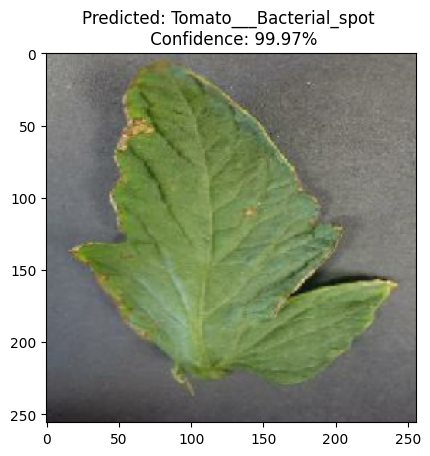

In [ ]:
img, predicted_class, confidence = predict_img("/content/Tomato_Bacterial_Spot.png", IMAGE_SIZE)
plt.title(f"Predicted: {predicted_class} \n Confidence: {confidence}%")
plt.imshow(img)
plt.show()

1/1 [==============================] - 0s 19ms/step
[[6.8069007e-06 9.9999309e-01 1.5963687e-07 7.6575669e-16 2.5888005e-13
  4.3224303e-16 1.1233440e-13 1.6005178e-13 2.9952053e-29 1.9947561e-23]]
1


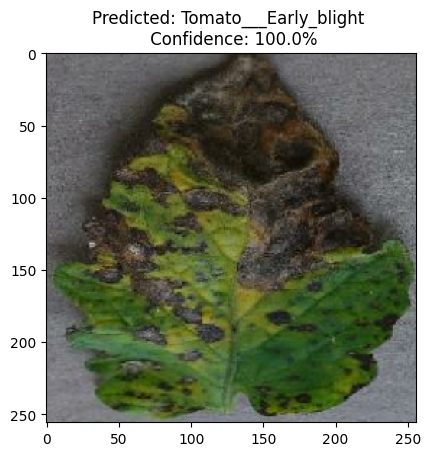

In [ ]:
img, predicted_class, confidence = predict_img("/content/Tomato_Early_Bright.png", IMAGE_SIZE)
plt.title(f"Predicted: {predicted_class} \n Confidence: {confidence}%")
plt.imshow(img)
plt.show()

1/1 [==============================] - 0s 20ms/step
[[7.1160220e-15 7.7485067e-12 3.7691440e-13 1.6123259e-12 8.2046704e-08
  1.4579646e-10 5.8509434e-12 1.1580231e-09 9.9999988e-01 1.1937016e-15]]
8


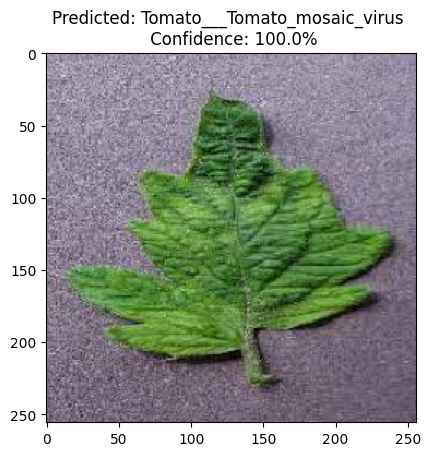

In [ ]:
img, predicted_class, confidence = predict_img("/content/images.jpg", IMAGE_SIZE)
plt.title(f"Predicted: {predicted_class} \n Confidence: {confidence}%")
plt.imshow(img)
plt.show()

1/1 [==============================] - 0s 21ms/step
[[1.05434605e-10 5.77921793e-02 5.82032644e-09 1.26961936e-07
  9.42207694e-01 8.47558108e-14 1.61876450e-08 7.46098838e-23
  1.41965944e-11 9.40604549e-19]]
4


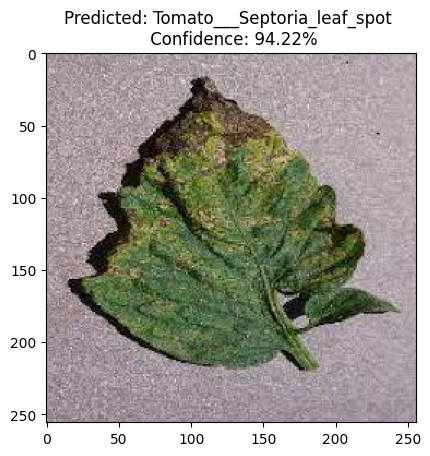

In [ ]:
img, predicted_class, confidence = predict_img("/content/Tomato.jpg", IMAGE_SIZE)
plt.title(f"Predicted: {predicted_class} \n Confidence: {confidence}%")
plt.imshow(img)
plt.show()